<a href="https://colab.research.google.com/github/misbahsy/APMonitor-do/blob/master/MovingHorizonEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Moving Horizon Estimation

Dynamic models constructed with equations that describe physical phenomena may need to be tuned by adjusting parameters so that predicted outputs match with experimental data. Physical models are based on the underlying physical principles that govern the problem and result from expressions such as a force or momentum balance and may include quantities such as velocity, acceleration, and position. Other quantities of interest may include anything that changes with respect to time such as reactor composition, temperature, mole fraction, etc. Mathematical models likely contain both physical and experimental elements. This section shows how to reconcile experimental data with the physical model through parameter estimation.

Moving Horizon Estimation (MHE) uses dynamic optimization and a backward time horizon of measurements to optimally adjust parameters and states. The data may include noise (random fluctuations), drift (gradual departure from true values), outliers (sudden and temporary departure from true values), or other inaccuracies. Nonlinear programming solvers are employed to numerically converge the dynamic optimization problem.

In [1]:
#@title ##Exercise
%%html
<p><strong>Objective:</strong> Design an estimator to predict an unknown parameter and state variable. Use a model of the reactor and implement the estimator to detect the current states (temperature and concentration) as well as the unmeasured heat transfer coefficient (U). <em>Estimated time: 2-3 hours.</em>
</p>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/cstr_estimation.zip' rel='nofollow'>CSTR Source Files</a></div>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/cstr.png' alt='' title='' /></div>
<p class='vspace'>A reactor is used to convert a hazardous chemical <strong>A</strong> to an acceptable chemical <strong>B</strong> in waste stream before entering a nearby lake. This particular reactor is dynamically modeled as a Continuously Stirred Tank Reactor (CSTR) with a simplified kinetic mechanism that describes the conversion of reactant <strong>A</strong> to product <strong>B</strong> with an irreversible and exothermic reaction. It is desired to maintain the temperature at a constant setpoint that maximizes the destruction of <strong>A</strong> (highest possible temperature). First, however, an estimator must predict the concentration of <strong>A</strong> because there is no direct measurement of this quantity. The reaction kinetics and dynamic equations are well-known but there is a parameter in the model, the heat transfer coefficient <strong>UA</strong>, that is unknown.
</p>
<p class='vspace'>Design an estimator to predict the concentration of <strong>A</strong> leaving the reactor and the heat transfer coefficient <strong>UA</strong> from the measured reactor temperature <strong>T</strong> and jacket temperature <strong>T<sub>c</sub></strong>. See a <a class='urllink' href='https://apmonitor.com/che436/index.php/Main/CaseStudyCSTR' rel='nofollow'>related CSTR case study</a> for details on the model.
</p>

In [2]:
#@title ##Solution
%%html
<p>The estimator can be any type such as a Kalman filter, Extended Kalman filter, Unscented Kalman Filter (particle filter), or an observer that can detect the states (T and Ca) along with the unknown parameter (U). The following solutions demonstrate an implementation of Moving Horizon Estimation.
</p>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/cstr_mhe_solution_matlab.zip' rel='nofollow'>CSTR MHE Solution in MATLAB</a></div>
<div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/cstr_mhe_solution_python.zip' rel='nofollow'>CSTR MHE Solution in Python</a></div>
<div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/cstr_mhe_solution.zip' rel='nofollow'>CSTR MHE Solution in Simulink</a></div>
<div class='vspace'></div>
<iframe width="560" height="315" src="https://www.youtube.com/embed/yQWgSByYjd8?rel=0" frameborder="0" allowfullscreen></iframe>


apm 34.73.12.88_cstr-sim <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           15
   Intermediates:            0
   Connections  :            0
   Equations    :            4
   Residuals    :            4
 
 Number of state variables:             13
 Number of total equations: -           13
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

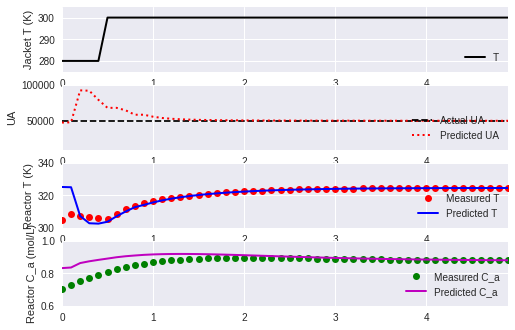

In [3]:
#@title GEKKO Solution
try:
    from pip import main as pipmain
except:
    from pip._internal import main as pipmain
pipmain(['install','gekko'])

from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

#%% Simulation

s = GEKKO(name='cstr-sim')

#1 step of simulation, discretization matches MHE
s.time = np.linspace(0,.1,2)

#Receive measurement from simulated control
Tc = s.MV(value=300,name='tc')
Tc.FSTATUS = 1 #receive measurement
Tc.STATUS = 0  #don't optimize

#State variables to watch
Ca = s.SV(value=.7, ub=1, lb=0,name='ca')
T = s.SV(value=305,lb=250,ub=500,name='t')

#other parameters
q = s.Param(value=100)
V = s.Param(value=100)
rho = s.Param(value=1000)
Cp = s.Param(value=0.239)
mdelH = s.Param(value=50000)
ER = s.Param(value=8750)
k0 = s.Param(value=7.2*10**10)
UA = s.Param(value=5*10**4)
Ca0 = s.Param(value=1)
T0 = s.Param(value=350)

#Variables
k = s.Var()
rate = s.Var()

#Rate equations
s.Equation(k==k0*s.exp(-ER/T))
s.Equation(rate==k*Ca)
#CSTR equations
s.Equation(V* Ca.dt() == q*(Ca0-Ca)-V*rate)
s.Equation(rho*Cp*V* T.dt() == q*rho*Cp*(T0-T) + V*mdelH*rate + UA*(Tc-T))

#Options
s.options.IMODE = 4 #dynamic simulation
s.options.NODES = 3
s.options.SOLVER = 3


#%% MHE

#Model

m = GEKKO(name='cstr-mhe')

#6 time points in horizon
m.time = np.linspace(0,.5,6)

#Parameter to Estimate
UA_mhe = m.FV(value=10*10**4,name='ua')
UA_mhe.STATUS = 1 #estimate
UA_mhe.FSTATUS = 0 #no measurements
#upper and lower bounds for optimizer
UA_mhe.LOWER = 10000
UA_mhe.UPPER = 100000

#Measurement input
Tc_mhe = m.MV(value=300,name='tc')
Tc_mhe.STATUS = 0 #don't estimate
Tc_mhe.FSTATUS = 1 #receive measurement

#Measurement to match simulation with
T_mhe = m.CV(value=325 ,lb=250,ub=500,name='t')
T_mhe.STATUS = 1  #minimize error between simulation and measurement
T_mhe.FSTATUS = 1 #receive measurement
T_mhe.MEAS_GAP = 0.1 #measurement deadband gap

#State to watch
Ca_mhe = m.SV(value=0.8, ub=1, lb=0,name='ca')

#Other parameters
q = m.Param(value=100)
V = m.Param(value=100)
rho = m.Param(value=1000)
Cp = m.Param(value=0.239)
mdelH = m.Param(value=50000)
ER = m.Param(value=8750)
k0 = m.Param(value=7.2*10**10)
Ca0 = m.Param(value=1)
T0 = m.Param(value=350)

#Equation variables(2 other DOF from CV and FV)
k = m.Var()
rate = m.Var()

#Reaction equations
m.Equation(k==k0*m.exp(-ER/T_mhe))
m.Equation(rate==k*Ca_mhe)
#CSTR equations
m.Equation(V* Ca_mhe.dt() == q*(Ca0-Ca_mhe)-V*rate) #mol balance
m.Equation(rho*Cp*V* T_mhe.dt() == q*rho*Cp*(T0-T_mhe) + V*mdelH*rate + UA_mhe*(Tc_mhe-T_mhe)) #energy balance


#Global Tuning
m.options.IMODE = 5 #MHE
m.options.EV_TYPE = 1
m.options.NODES = 3
m.options.SOLVER = 3 #IPOPT

#%% Loop

# number of cycles to run
cycles = 50

# step in the jacket cooling temperature at cycle 6
Tc_meas = np.empty(cycles)
Tc_meas[0:15] = 280
Tc_meas[5:cycles] = 300
dt = 0.1 # min
time = np.linspace(0,cycles*dt-dt,cycles) # time points for plot

# allocate storage
Ca_meas = np.empty(cycles)
T_meas = np.empty(cycles)
UA_mhe_store = np.empty(cycles)
Ca_mhe_store = np.empty(cycles)
T_mhe_store = np.empty(cycles)



for i in range(cycles):

    ## Process
    # input Tc (jacket cooling temperature)
    Tc.MEAS = Tc_meas[i]
    # simulate process model, 1 time step
    s.solve()
    # retrieve Ca and T measurements from the process
    Ca_meas[i] = Ca.MODEL
    T_meas[i] = T.MODEL

    ## Estimator
    # input process measurements
    # input Tc (jacket cooling temperature)
    Tc_mhe.MEAS = Tc_meas[i]
    # input T (reactor temperature)
    T_mhe.MEAS = T_meas[i] #CV

    # solve process model, 1 time step
    m.solve()
    # check if successful
    if m.options.APPSTATUS == 1:
        # retrieve solution
        UA_mhe_store[i] = UA_mhe.NEWVAL
        Ca_mhe_store[i] = Ca_mhe.MODEL
        T_mhe_store[i] = T_mhe.MODEL
    else:
        # failed solution
        UA_mhe_store[i] = 0
        Ca_mhe_store[i] = 0
        T_mhe_store[i] = 0

    print('MHE results: Ca (estimated)=' + str(Ca_mhe_store[i]) + \
        ' Ca (actual)=' + str(Ca_meas[i]) + \
        ' UA (estimated)=' + str(UA_mhe_store[i]) + \
        ' UA (actual)=50000')

#%% plot results
plt.figure()
plt.subplot(411)
plt.plot(time,Tc_meas,'k-',linewidth=2)
plt.axis([0,time[-1],275,305])
plt.ylabel('Jacket T (K)')
plt.legend('T_c')

plt.subplot(412)
plt.plot([0,time[-1]],[50000,50000],'k--')
plt.plot(time,UA_mhe_store,'r:',linewidth=2)
plt.axis([0,time[-1],10000,100000])
plt.ylabel('UA')
plt.legend(['Actual UA','Predicted UA'],loc=4)

plt.subplot(413)
plt.plot(time,T_meas,'ro')
plt.plot(time,T_mhe_store,'b-',linewidth=2)
plt.axis([0,time[-1],300,340])
plt.ylabel('Reactor T (K)')
plt.legend(['Measured T','Predicted T'],loc=4)

plt.subplot(414)
plt.plot(time,Ca_meas,'go')
plt.plot(time,Ca_mhe_store,'m-',linewidth=2)
plt.axis([0,time[-1],.6,1])
plt.ylabel('Reactor C_a (mol/L)')
plt.legend(['Measured C_a','Predicted C_a'],loc=4)
plt.show()
